Consider the following input sentence, which has already been embedded into 3-
dimensional vectors.

We choose a small embedding dimension for
illustration purposes to ensure it fits on the page without line breaks:


In [1]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

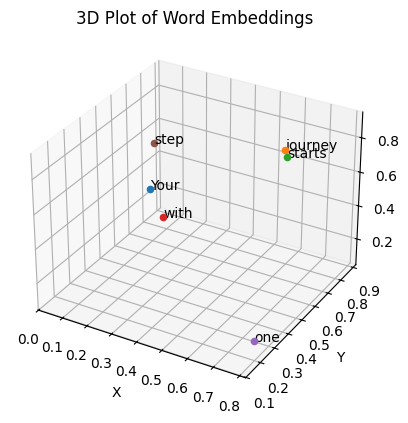

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Corresponding words
words = ['Your', 'journey', 'starts', 'with', 'one', 'step']

# Extract x, y, z coordinates
x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point and annotate with corresponding word
for x, y, z, word in zip(x_coords, y_coords, z_coords, words):
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=10)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of Word Embeddings')
plt.show()

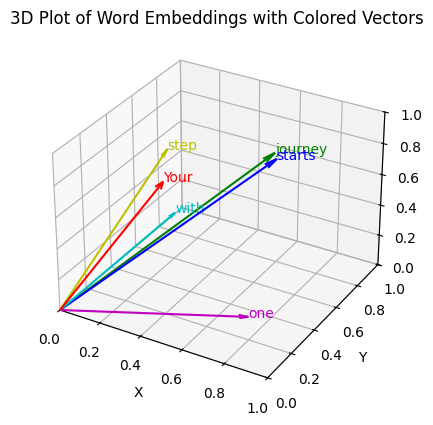

In [3]:
# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()


Each row represents a word, and each column represents an embedding dimension


Let's select the second input token as the query


In [4]:
query = inputs[1]  # 2nd input token is the query

attn_scores_2 = torch.empty(inputs.shape[0]) # This creates a empty tensor of length = len(inputs tensor)
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query) # dot product (transpose not necessary here since they are 1-dim vectors)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In the next step, we normalize each of the attention scores that
we computed previously.

The main goal behind the normalization  is to obtain attention weights
that sum up to 1.

This normalization is a convention that is useful for interpretation and for
maintaining training stability in an LLM.

Here's a straightforward method for achieving this
normalization step:

In [5]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


In practice, it's more common and advisable to use the **softmax function** for normalization.

This approach is better at managing extreme values and offers more favorable gradient
properties during training.

Below is a basic implementation of the softmax function for
normalizing the attention scores:

In [6]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


As the output shows, the softmax function also meets the objective and normalizes the
attention weights such that they sum to 1:

In addition, the softmax function ensures that the attention weights are always positive.
This makes the output interpretable as probabilities or relative importance, where higher
weights indicate greater importance.

Note that this naive softmax implementation (softmax_naive) may encounter numerical
instability problems, such as overflow and underflow, when dealing with large or small input
values.

Therefore, in practice, it's advisable to use the PyTorch implementation of softmax,
which has been extensively optimized for performance:

In [7]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)



The context vector z(2)is calculated as a weighted sum of all input
vectors.

This involves multiplying each input vector by its corresponding attention weight:


In [8]:
query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape) # Creating a empty vector of same size as token embedding
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

# for example assume:
'''
inputs = torch.tensor([
  [0.1, 0.3, 0.5],
  [0.2, 0.4, 0.6],
  [0.3, 0.5, 0.7]
])

attn_weights_2 = tensor([0.29, 0.33, 0.38])
'''
# input_vector(X_i) * attention_weights_2(0.29) = [0.029, 0.087, 0.145]

#context_vec_2 = [0.029+0.066+0.114, 0.087+0.132+0.190, 0.145+0.198+0.266]
#context_vec_2 = [0.209, 0.409, 0.609]



tensor([0.4419, 0.6515, 0.5683])


'\ninputs = torch.tensor([\n  [0.1, 0.3, 0.5],\n  [0.2, 0.4, 0.6],\n  [0.3, 0.5, 0.7]\n])\n\nattn_weights_2 = tensor([0.29, 0.33, 0.38])\n'

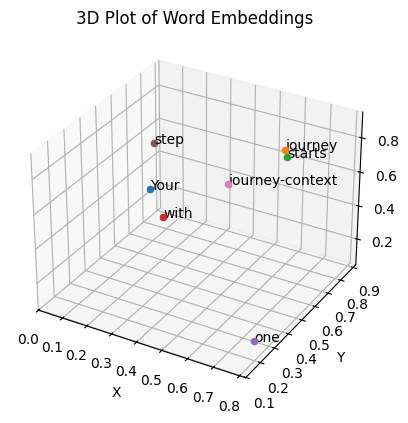

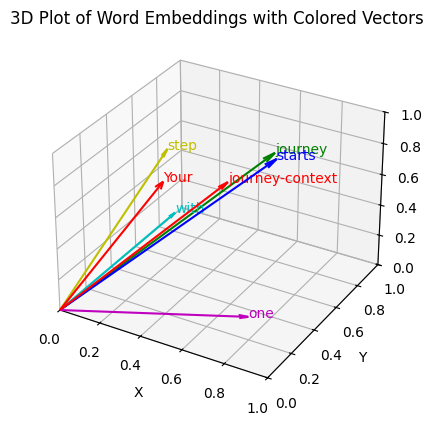

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55], # step     (x^6)
   [0.4419, 0.6515, 0.5683]]  # Updating the inputs tensor to include the journery context vector
)

# Corresponding words
words = ['Your', 'journey', 'starts', 'with', 'one', 'step', 'journey-context']

# Extract x, y, z coordinates
x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point and annotate with corresponding word
for x, y, z, word in zip(x_coords, y_coords, z_coords, words):
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=10)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of Word Embeddings')
plt.show()

# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'r']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()

Now, we can extend this computation to
calculate attention weights and context vectors for all inputs.

Each element in the preceding tensor represents an attention score between each pair of
inputs.

When computing the preceding attention score tensor, we can use for-loops in Python.
                                                            
However, for-loops are generally slow, and we can achieve the same results using matrix
multiplication:

In [12]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310, 0.7935],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865, 1.1849],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605, 1.1694],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565, 0.6626],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935, 0.5600],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450, 0.8559],
        [0.7935, 1.1849, 1.1694, 0.6626, 0.5600, 0.8559, 0.9427]])


We now normalize each row so that the values in
each row sum to 1:

In [13]:
attn_weights = torch.softmax(attn_scores, dim=-1)
print(attn_weights)

tensor([[0.1792, 0.1713, 0.1692, 0.1061, 0.1042, 0.1240, 0.1459],
        [0.1180, 0.2026, 0.1986, 0.1056, 0.0921, 0.1346, 0.1486],
        [0.1184, 0.2017, 0.1981, 0.1058, 0.0943, 0.1332, 0.1485],
        [0.1223, 0.1768, 0.1744, 0.1246, 0.1077, 0.1467, 0.1476],
        [0.1305, 0.1675, 0.1689, 0.1169, 0.1607, 0.1108, 0.1446],
        [0.1180, 0.1861, 0.1813, 0.1211, 0.0842, 0.1615, 0.1478],
        [0.1277, 0.1889, 0.1860, 0.1121, 0.1011, 0.1359, 0.1483]])


In the context of using PyTorch, the dim parameter in functions like torch.softmax specifies
the dimension of the input tensor along which the function will be computed.

By setting
dim=-1, we are instructing the softmax function to apply the normalization along the last
dimension of the attn_scores tensor.

If attn_scores is a 2D tensor (for example, with a
shape of [rows, columns]), dim=-1 will normalize across the columns so that the values in
each row (summing over the column dimension) sum up to 1.

In the third and last step, we now use these attention weights to compute all context
vectors via matrix multiplication:


In [15]:
all_context_vecs = attn_weights @ inputs
# Attention_weighs(7x7) @ inputs(7x3) = 7x3 matrix. Inner numbers should be same and outer numbers become the dimension of new vectors.
# The context vector was appended to the inputs when plotting the graph
print(all_context_vecs)

tensor([[0.4420, 0.6016, 0.5774],
        [0.4419, 0.6515, 0.5683],
        [0.4429, 0.6499, 0.5673],
        [0.4321, 0.6330, 0.5536],
        [0.4635, 0.5997, 0.5326],
        [0.4213, 0.6505, 0.5651],
        [0.4397, 0.6372, 0.5635]])


In [16]:
print("Previous 2nd context vector:", context_vec_2)

Previous 2nd context vector: tensor([0.4419, 0.6515, 0.5683])


Based on the result, we can see that the previously calculated context_vec_2 matches the
second row in the previous tensor exactly